In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *

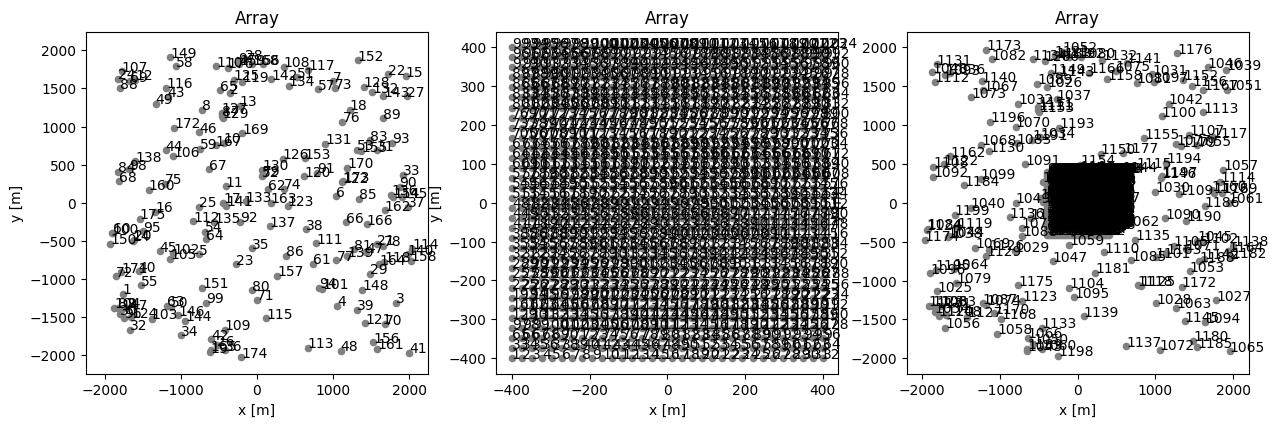

In [ ]:
# random_antenna_arr(n_antenna=3, E_lim=1000, N_lim=1000, U_lim=0) -> [[E1, N1, U1], [E2, N2, U2], ...]
E_lim = 4000.
N_lim = 4000.
n = 176
array_random = random_antenna_arr(n_antenna=n, E_lim=E_lim, N_lim=N_lim)

# uni_antenna_array(n_antenna_E=32, n_antenna_N=32, E_lim=800, N_lim=800, U_lim=0) -> [[E1, N1, U1], [E2, N2, U2], ...]
n_grid = 32
E_lim_grid = 800.
N_lim_grid = 800.
array_grid = uni_antenna_array(n_antenna_E=n_grid, n_antenna_N=n_grid, E_lim=E_lim_grid, N_lim=N_lim_grid)

# Concatenate the random arrays and the uniform ones
antenna = np.concatenate((array_grid,array_random),axis=0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_antenna_arr(array_random, ax=ax[0], fig=fig)
plot_antenna_arr(array_grid, ax=ax[1], fig=fig)
plot_antenna_arr(antenna, ax=ax[2], fig=fig)

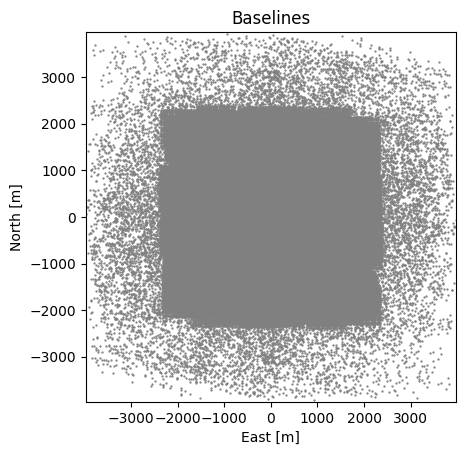

In [7]:
baselines = get_baselines(antenna)
plot_baselines(baselines, ENU=True)

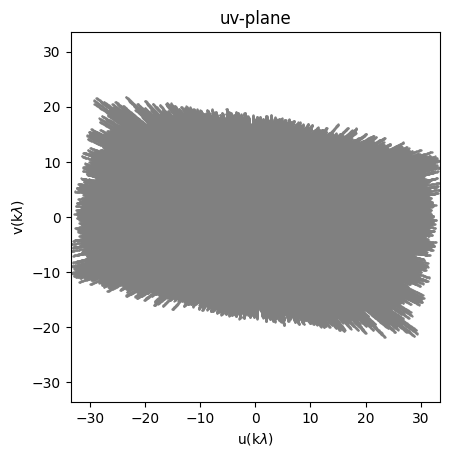

In [40]:
# Multiband parameters
bandwidth = 1000e6
n_freqs = 128
f = 2000e6 # 2 GHz, lambda = 0.15 m

# Source tracking parameters
source_decl = 90./180*np.pi
array_lat = 35./180*np.pi # Heraklion latitud
track_time = 1
delta_t = 15/60 # 300 secs
t_0 = -0.5
n_times = 1 #int(track_time/delta_t)

track, _ = uv_track_multiband(baselines, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)

plot_baselines(track)

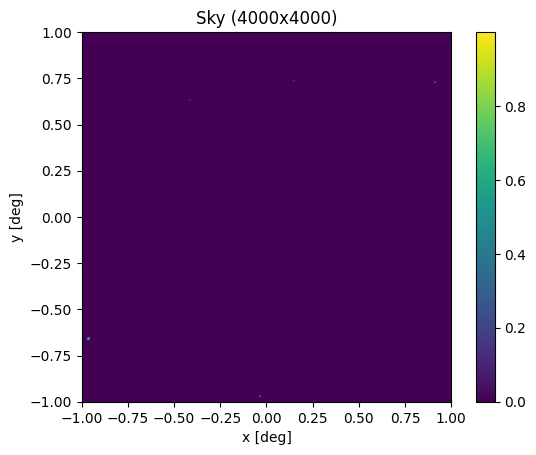

In [50]:
Npx = 4000
fov_size = (2., 2.) # 3 degrees FOV from 6 m parabolic dishes.
deg_size_list = np.array([.01, .005, .005, .003, .003])
source_intensity_list = [1, 1, 1, 1, 1]
sky = n_source_sky((Npx, Npx), fov_size[0], deg_size_list, source_intensity_list, seed=902)
plot_sky(sky, fov_size)

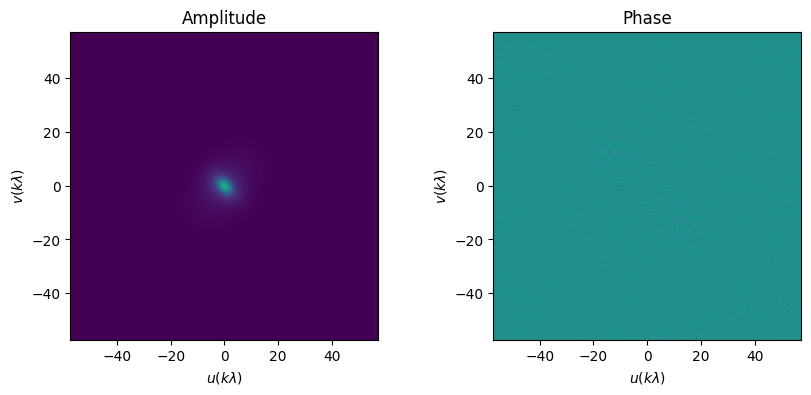

In [51]:
# Fourier transform of the sky
sky_uv = sky2uv(sky)
plot_sky_uv(sky_uv, fov_size)

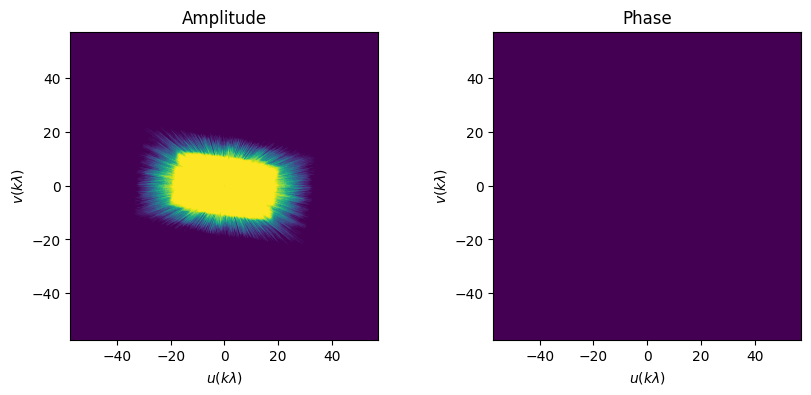

In [52]:
# Fourier transform of the mask
uv_mask, uv_sample_indices  = grid_uv_samples(track, sky_uv.shape, fov_size)
plot_sky_uv(uv_mask, fov_size)

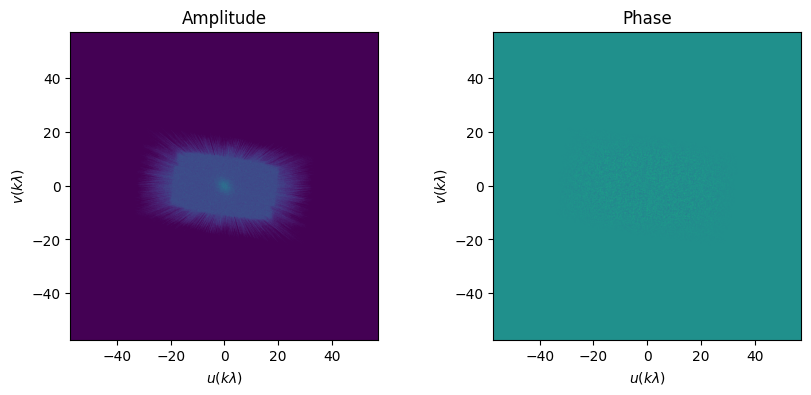

In [53]:
# Noisy visibilities
sigma = 0.1
vis = compute_visibilities_grid(sky_uv, uv_mask)
vis = add_noise_uv(vis, uv_mask, sigma)
plot_sky_uv(vis, fov_size)

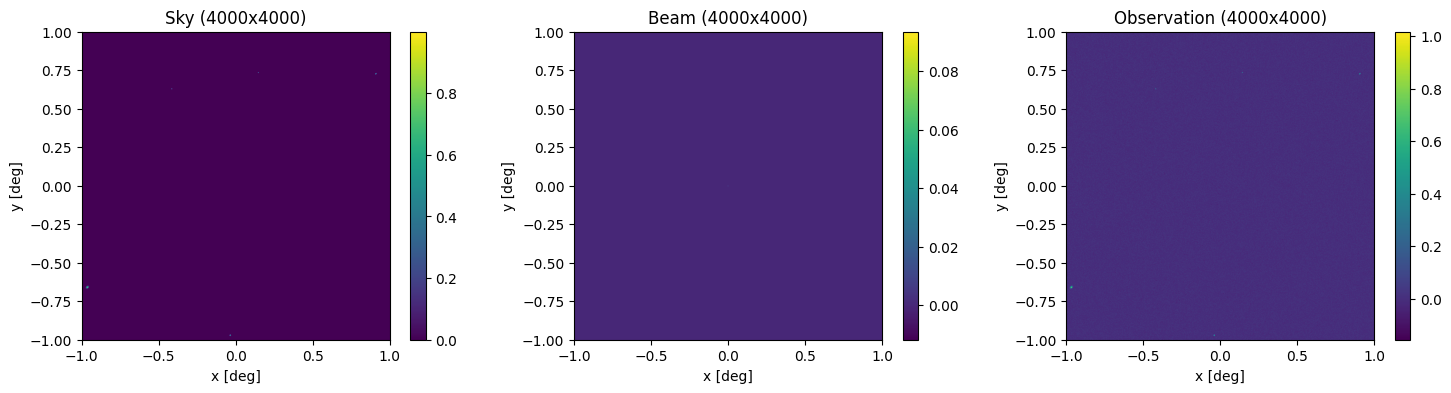

In [54]:
obs = uv2sky(vis)
beam = uv2sky(uv_mask)

fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, fov_size, ax[0], fig, 'Sky')
plot_sky(beam, fov_size, ax[1], fig, 'Beam')
plot_sky(obs, fov_size, ax[2], fig, 'Observation')

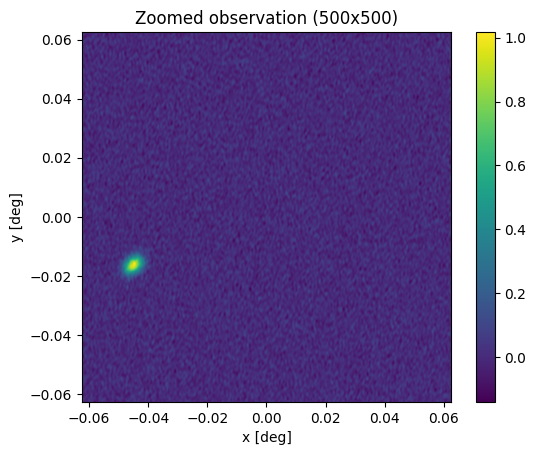

In [59]:
plot_sky(obs[500:1000,:500], title='Zoomed observation', fov_size=(1.*500/obs.shape[0], 1.*500/obs.shape[0]))

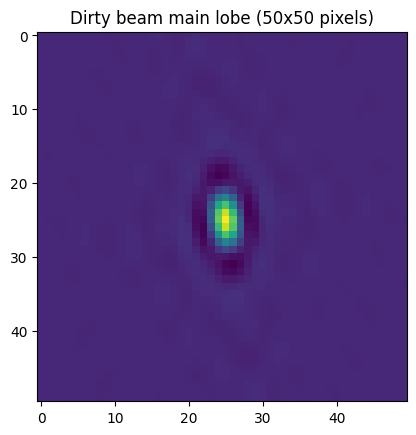

In [56]:
main_lobe_px = 50
plt.imshow(beam[Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2,Npx//2-main_lobe_px//2:Npx//2+main_lobe_px//2])
plt.title('Dirty beam main lobe ({}x{} pixels)'.format(main_lobe_px, main_lobe_px))
plt.show()

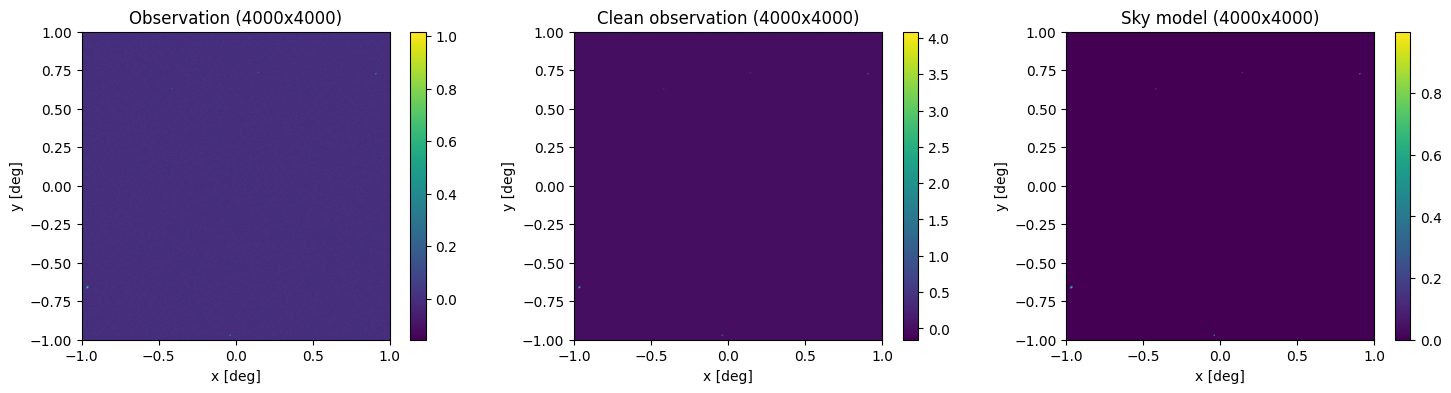

In [57]:
I_clean, sky_model = clean_hogbom(obs, beam, 0.2, 100, 1e-3 , clean_beam_size_px=10)

# Plot clean observation
fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(obs, fov_size, ax[0], fig, 'Observation')
plot_sky(I_clean, fov_size, ax[1], fig, 'Clean observation')
plot_sky(sky, fov_size, ax[2], fig, 'Sky model')


# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()

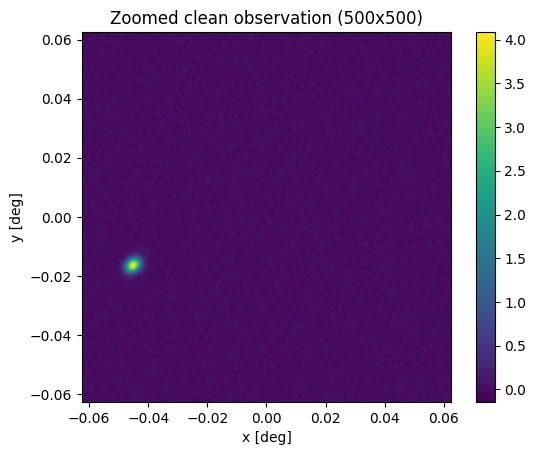

In [60]:
plot_sky(I_clean[500:1000,:500], title='Zoomed clean observation', fov_size=(1.*500/obs.shape[0], 1.*500/obs.shape[0]))